# Skin Type Recognition

**Domain :** Machine Learning / AI

**Problem Name :** Build Mathematical model using ML and signal processing concept to process the skin issues into dryness and oiliness.

**Description :** Patients face a lot of problems with their skin. The main issue remains with the type of skin they have. Depending on the type of skin various skin diseases can occur. So if the skin is too dry it may start to peel and lead to various skin diseases like Psoriasis, Eczema etc. likewise too oily skin can lead to pimples which in turn can lead to scars. So the identification of skin type is of utmost need.

In [ ]:
# downloading helper_functions.py
! wget https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py

--2022-01-22 10:08:42--  https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10139 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.90K  --.-KB/s    in 0s      

2022-01-22 10:08:42 (72.5 MB/s) - ‘helper_functions.py’ saved [10139/10139]



In [ ]:
# Importing dependancies
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_functions import plot_loss_curves, compare_historys, make_confusion_matrix

In [ ]:
# Setting dir paths
oil_dir = "/content/drive/MyDrive/skin-dataset/oily"
dry_dir = "/content/drive/MyDrive/skin-dataset/dry"

In [ ]:
# Getting all the paths in a list for oil and dry skins
oil_list = []
for path in os.listdir(oil_dir):
  oil_list.append(oil_dir + "/" + path)

dry_list = []
for path in os.listdir(dry_dir):
  dry_list.append(dry_dir + "/" + path)

In [ ]:
# Preprocess img function
IMG_SIZE = (224, 224)
def load_and_prep(filepath):
  img_path = tf.io.read_file(filepath)
  img = tf.io.decode_image(img_path)
  img = tf.image.resize(img, IMG_SIZE)

  return img

In [ ]:
# Getting only those images which are suitable 
def corrImgs(arr):
  corrImgList = []
  for path in arr:
    img = load_and_prep(path)
    if (img.shape[2] == 3) | (img.shape == 4):
      corrImgList.append(path)
  
  return corrImgList

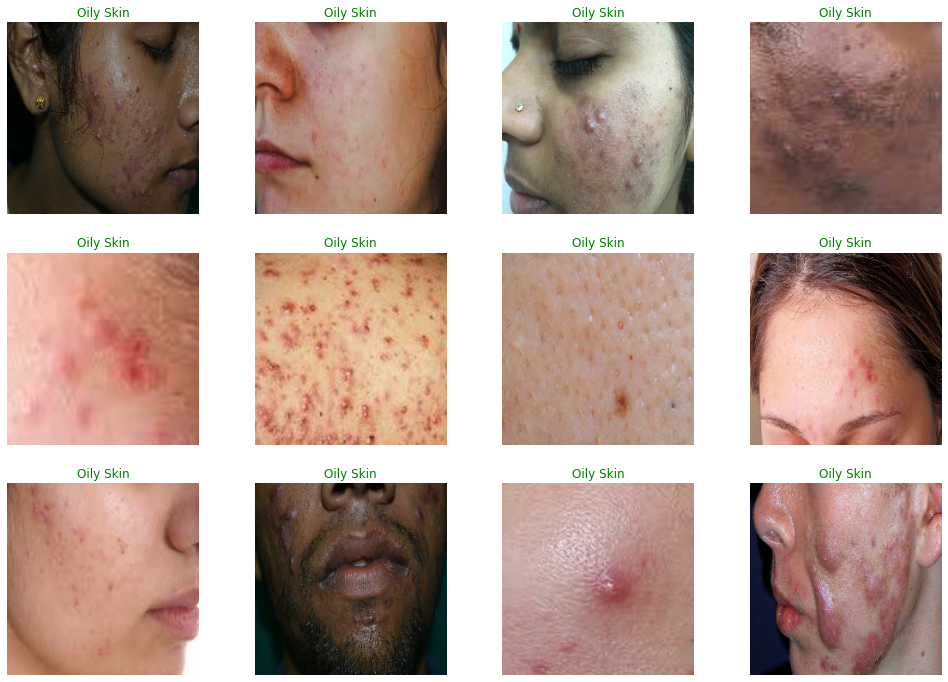

In [ ]:
# Randomly plotting the Oily Skin images
random_oil_skin = np.random.choice(oil_list, size=12, replace=False)
plt.figure(figsize=(17, 12))
for i in range(12):
  img_path = random_oil_skin[i]
  img = load_and_prep(img_path)

  # plotting the images
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(img/255)
  plt.title("Oily Skin", color="green")

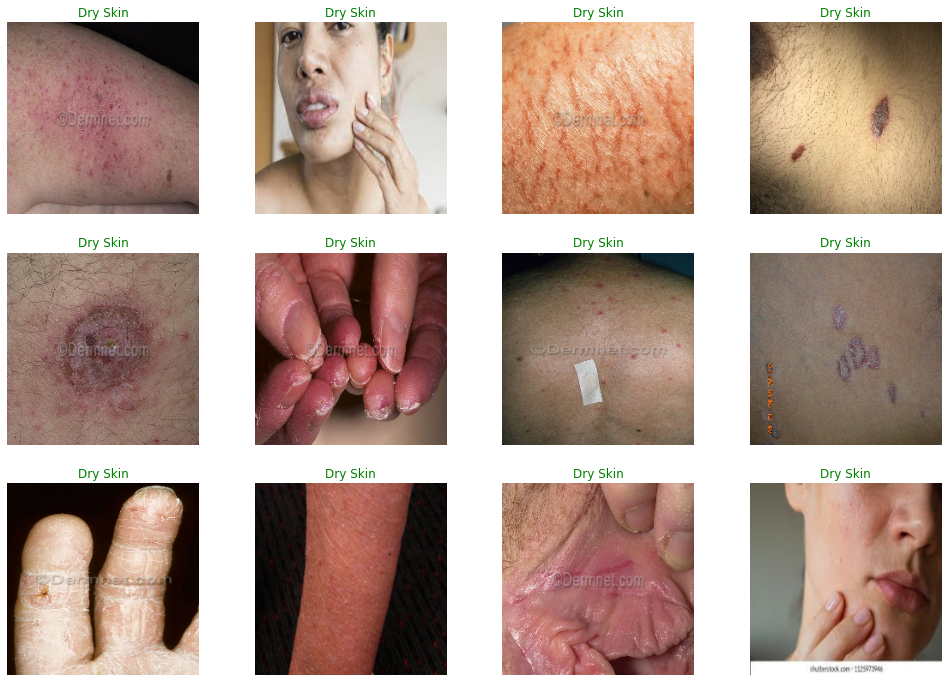

In [ ]:
# Randomly plotting the Dry Skin images
random_dry_skin = np.random.choice(dry_list, size=12, replace=False)
plt.figure(figsize=(17, 12))
for i in range(12):
  img_path = random_dry_skin[i]
  img = load_and_prep(img_path)

  # plotting the images
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(img/255)
  plt.title("Dry Skin", color="green")

In [ ]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

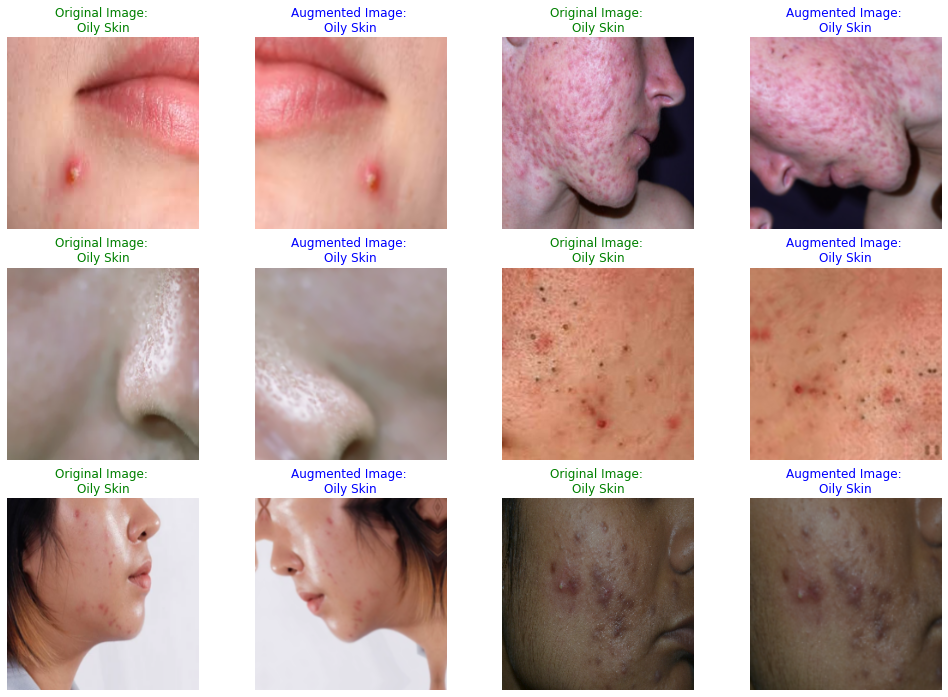

In [ ]:
# Visualizing multiple randomly augmented oily skin images
plt.figure(figsize=(17, 12))
for i in range(1, 12, 2):
  random_class = "Oily Skin"
  random_img_path = random.choice(oil_list)

  img = load_and_prep(random_img_path)
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))
  aug_img = tf.image.resize(aug_img[0], IMG_SIZE)

  # Plotting original image
  plt.subplot(3, 4, i)
  plt.axis(False)
  plt.imshow(img / 255)
  plt.title(f"Original Image: \n{random_class}", color="green")

  # Plotting augmented image
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(aug_img / 255)
  plt.title(f"Augmented Image: \n{random_class}", color="blue");

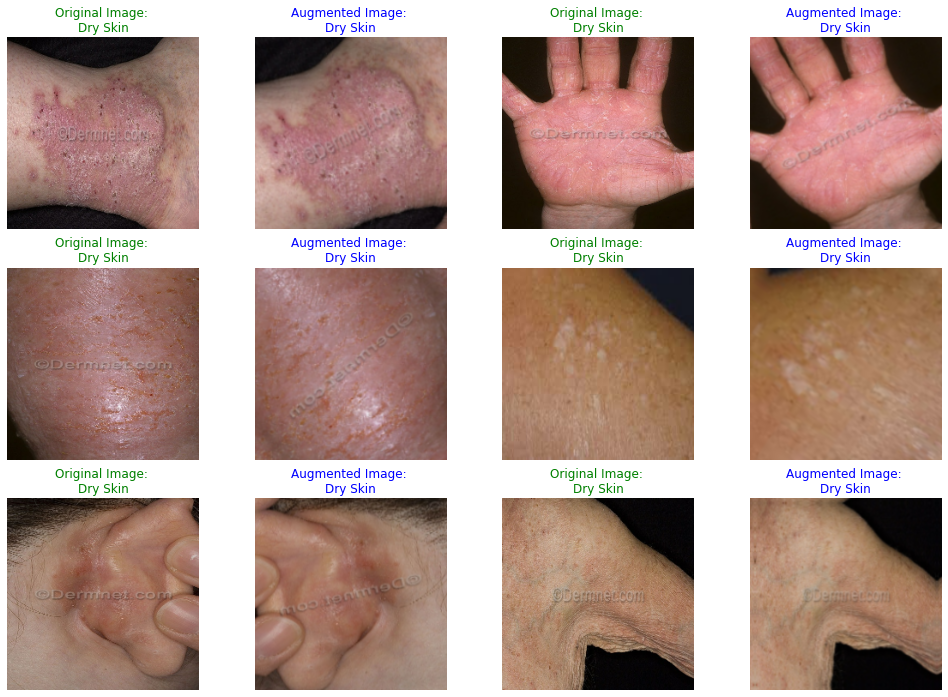

In [ ]:
# Visualizing multiple randomly augmented dry skin images
plt.figure(figsize=(17, 12))
for i in range(1, 12, 2):
  random_class = "Dry Skin"
  random_img_path = random.choice(dry_list)

  img = load_and_prep(random_img_path)
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))
  aug_img = tf.image.resize(aug_img[0], IMG_SIZE)

  # Plotting original image
  plt.subplot(3, 4, i)
  plt.axis(False)
  plt.imshow(img / 255)
  plt.title(f"Original Image: \n{random_class}", color="green")

  # Plotting augmented image
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(aug_img / 255)
  plt.title(f"Augmented Image: \n{random_class}", color="blue");

In [ ]:
# Train test splits
data_gen = ImageDataGenerator(validation_split=0.2)

train_data = data_gen.flow_from_directory(directory="/content/drive/MyDrive/skin-dataset",
                                          subset='training',
                                          target_size=IMG_SIZE)

test_data = data_gen.flow_from_directory(directory="/content/drive/MyDrive/skin-dataset",
                                         subset='validation',
                                         target_size=IMG_SIZE)

Found 412 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [ ]:
len(train_data), len(test_data)

(13, 4)

## Building the Model

In [ ]:
# Setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting up input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = tf.keras.layers.Dense(2, activation="softmax", name="output_layer")(x) 
model_1 = tf.keras.Model(inputs, outputs)

# compiling the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25 * len(test_data))

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/5
13/13 [==============================] - 91s 6s/step - loss: 0.5895 - accuracy: 0.6602 - val_loss: 0.3853 - val_accuracy: 0.7188
Epoch 2/5
13/13 [==============================] - 13s 1s/step - loss: 0.3623 - accuracy: 0.8592 - val_loss: 0.2054 - val_accuracy: 0.9375
Epoch 3/5
13/13 [==============================] - 11s 838ms/step - loss: 0.2715 - accuracy: 0.9175 - val_loss: 0.1140 - val_accuracy: 0.9688
Epoch 4/5
13/13 [==============================] - 9s 692ms/step - loss: 0.2356 - accuracy: 0.9417 - val_loss: 0.2183 - val_accuracy: 0.9062
Epoch 5/5
13/13 [==============================] - 10s 744ms/step - loss: 0.2117 - accuracy: 0.9490 - val_loss: 0.1053 - val_accuracy: 0.9688


In [ ]:
# Evaluating the model
model_1.evaluate(test_data)

4/4 [==============================] - 2s 354ms/step - loss: 0.1568 - accuracy: 0.9608


[0.15681104362010956, 0.9607843160629272]

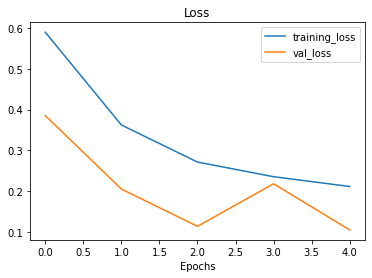

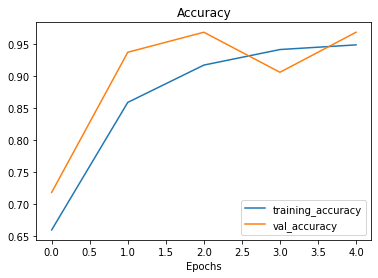

In [ ]:
# Plotting loss curves
plot_loss_curves(history_1)

In [ ]:
# Saving the model 
model_1.save("/content/drive/MyDrive/Skin-Type-Recognition", save_format="h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 10 

history_1_fine_tune_1 = model_1.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps= 0.25 * len(test_data), 
                                    initial_epoch=history_1.epoch[-1])

Epoch 5/10
13/13 [==============================] - 17s 859ms/step - loss: 0.1901 - accuracy: 0.9223 - val_loss: 0.1188 - val_accuracy: 0.9688
Epoch 6/10
13/13 [==============================] - 9s 720ms/step - loss: 0.1455 - accuracy: 0.9490 - val_loss: 0.1223 - val_accuracy: 0.9375
Epoch 7/10
13/13 [==============================] - 9s 710ms/step - loss: 0.1417 - accuracy: 0.9466 - val_loss: 0.1186 - val_accuracy: 0.9688
Epoch 8/10
13/13 [==============================] - 9s 676ms/step - loss: 0.1099 - accuracy: 0.9612 - val_loss: 0.0593 - val_accuracy: 0.9688
Epoch 9/10
13/13 [==============================] - 9s 734ms/step - loss: 0.1121 - accuracy: 0.9563 - val_loss: 0.1158 - val_accuracy: 0.9375
Epoch 10/10
13/13 [==============================] - 9s 689ms/step - loss: 0.0918 - accuracy: 0.9709 - val_loss: 0.0948 - val_accuracy: 0.9375


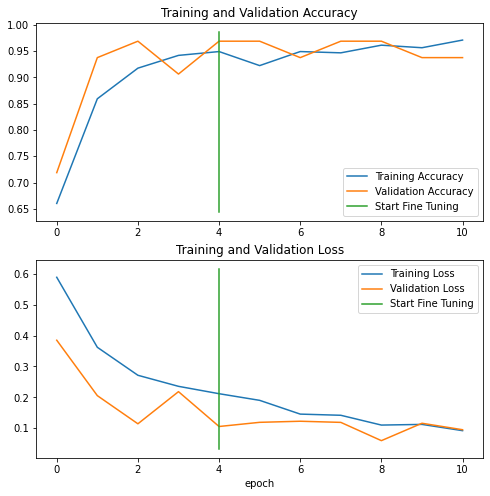

In [ ]:
compare_historys(history_1, history_1_fine_tune_1)

In [ ]:
# Model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 784,002
Non-trainab

In [ ]:
# Getting test image file paths
test_data_img_paths = test_data.filepaths
np.random.shuffle(test_data_img_paths)

# Getting labels
test_data_labels = []
for path in test_data_img_paths:
  test_data_labels.append(path.split("/")[5])

# Creating a dataframe of test paths
df_test_data_img_paths = pd.DataFrame({"Img Paths": test_data_img_paths,
                                       "Labels": test_data_labels})

df_test_data_img_paths.head()

Img Paths Labels
0  /content/drive/MyDrive/skin-dataset/oily/oily(...   oily
1  /content/drive/MyDrive/skin-dataset/dry/dry(11...    dry
2  /content/drive/MyDrive/skin-dataset/dry/dry(10...    dry
3  /content/drive/MyDrive/skin-dataset/dry/dry(16...    dry
4  /content/drive/MyDrive/skin-dataset/dry/dry(11...    dry

In [ ]:
len(df_test_data_img_paths)

102

In [ ]:
# Generating a test dataset for 
test_data_shuff = data_gen.flow_from_dataframe(df_test_data_img_paths, 
                                               directory="/content/drive/MyDrive/skin-dataset", 
                                               x_col='Img Paths', y_col='Labels',
                                               shuffle=False,
                                               target_size=(224, 224))

Found 102 validated image filenames belonging to 2 classes.


In [ ]:
# Loading the best model
# The same model architecture was trained on tensorflow==2.3.0 and then loaded here, trained on Tesla-K80
model = tf.keras.models.load_model("/content/drive/MyDrive/Skin-Type-Recognition-Degraded")

In [ ]:
# Getting prediction probabilites
pred_prob = model.predict(test_data_shuff)
pred_prob[:20]

array([[7.6614106e-01, 2.3385891e-01],
       [9.9909520e-01, 9.0478896e-04],
       [9.9911290e-01, 8.8703842e-04],
       [9.9727708e-01, 2.7229942e-03],
       [9.6808672e-01, 3.1913277e-02],
       [9.8997855e-01, 1.0021459e-02],
       [9.9320269e-01, 6.7972932e-03],
       [9.8444760e-01, 1.5552406e-02],
       [9.9754411e-01, 2.4558755e-03],
       [6.2689155e-02, 9.3731087e-01],
       [9.7319329e-01, 2.6806701e-02],
       [4.5685384e-01, 5.4314619e-01],
       [9.9597025e-01, 4.0298323e-03],
       [9.9836093e-01, 1.6390317e-03],
       [3.6272076e-01, 6.3727927e-01],
       [2.3828545e-01, 7.6171458e-01],
       [9.9852449e-01, 1.4755410e-03],
       [4.1961884e-01, 5.8038116e-01],
       [9.9887592e-01, 1.1241277e-03],
       [9.5371366e-01, 4.6286333e-02]], dtype=float32)

In [ ]:
y_pred = pred_prob.argmax(axis=1)
y_pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [ ]:
# Labels 
test_data.class_indices

{'dry': 0, 'oily': 1}

In [ ]:
# Converting our text labels into numbers
y_true = []
for label in test_data_labels:
  label_ = 0 if label == "dry" else 1
  y_true.append(label_)

y_true  = np.array(y_true)
y_true[:20]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0])

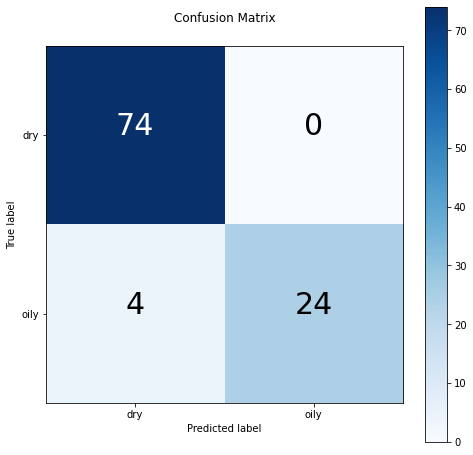

In [ ]:
# Plotting a confusion matrix
class_names = ["dry", "oily"]

make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(8, 8),
                      text_size=30,
                      norm=False)

In [ ]:
# To get suitable images
corrImgList = corrImgs(test_data_img_paths)

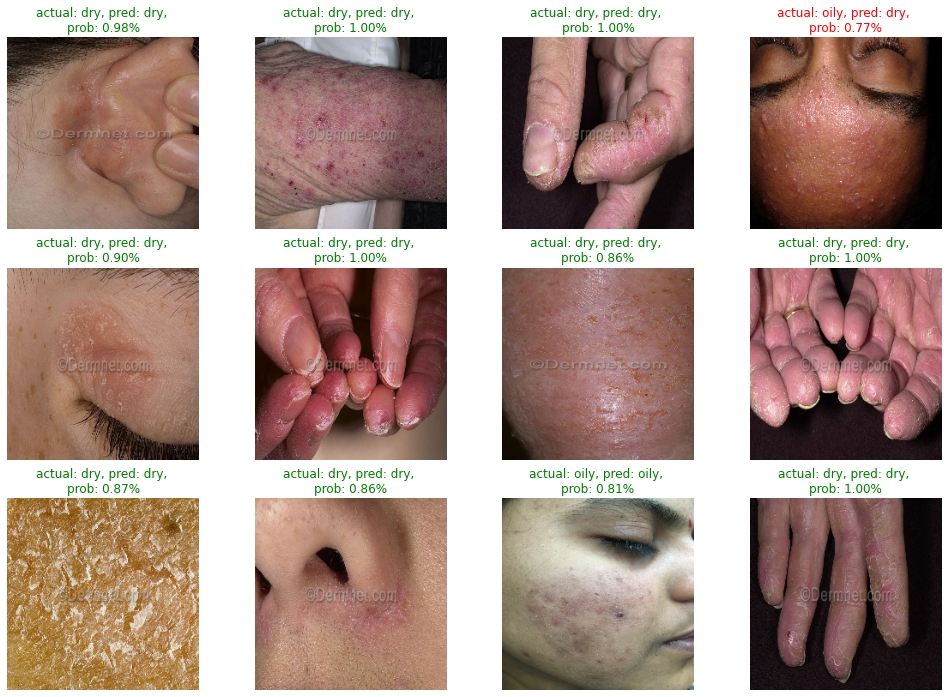

In [ ]:
path_list = np.random.choice(corrImgList, size=12, replace=False)
plt.figure(figsize=(17, 12))
for i in range(12):
  img_path = path_list[i]
  class_name = img_path.split("/")[5]
  img = load_and_prep(img_path)

  pred_prob  = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
  plt.subplot(3, 4, i+1)
  plt.imshow(img/255.)
  title_color = "g" if class_name == pred_class else "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, \nprob: {pred_prob.max():.2f}%", c=title_color)
  plt.axis(False);

In [ ]:
# Getting test labels
test_labels = []
for path in test_data_img_paths:
  test_labels.append(path.split("/")[5])

test_labels[:5]

['oily', 'dry', 'dry', 'dry', 'dry']

In [ ]:
df_pred = pd.DataFrame({"filename" : test_data_img_paths,
                         "label": test_labels,
                         "True": y_true,
                         "pred": y_pred})

df_pred.head(10)

filename label  True  pred
0  /content/drive/MyDrive/skin-dataset/oily/oily(...  oily     1     0
1  /content/drive/MyDrive/skin-dataset/dry/dry(11...   dry     0     0
2  /content/drive/MyDrive/skin-dataset/dry/dry(10...   dry     0     0
3  /content/drive/MyDrive/skin-dataset/dry/dry(16...   dry     0     0
4  /content/drive/MyDrive/skin-dataset/dry/dry(11...   dry     0     0
5  /content/drive/MyDrive/skin-dataset/dry/dry(16...   dry     0     0
6  /content/drive/MyDrive/skin-dataset/dry/dry(16...   dry     0     0
7  /content/drive/MyDrive/skin-dataset/dry/dry(17...   dry     0     0
8  /content/drive/MyDrive/skin-dataset/dry/dry(12...   dry     0     0
9  /content/drive/MyDrive/skin-dataset/oily/oily(...  oily     1     1

In [ ]:
df_pred.to_csv("test-preds.csv")

In [ ]:
len(test_data_img_paths)

102

In [ ]:
# Wrong predicted images
wrng_pred_test_paths = []
for i in range(len(test_data_img_paths)):
  if y_true[i] != y_pred[i]:
    wrng_pred_test_paths.append(test_data_img_paths[i])

len(wrng_pred_test_paths)

4

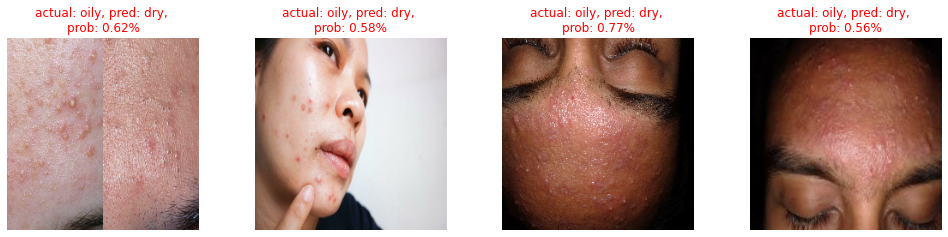

In [ ]:
# Wrongly predicted images
plt.figure(figsize=(17, 12))
for i in range(4):
  img_path = wrng_pred_test_paths[i]
  class_name = img_path.split("/")[5]
  img = load_and_prep(img_path)

  pred_prob  = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
  plt.subplot(3, 4, i+1)
  plt.imshow(img/255.)
  title_color = "g" if class_name == pred_class else "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, \nprob: {pred_prob.max():.2f}%", c=title_color)
  plt.axis(False);